Series GSE125088		Query DataSets for GSE125088
Status	Public on Jan 16, 2019
Title	Characterization of embryonic osteoclast precursors
Organism	Mus musculus
Experiment type	Expression profiling by high throughput sequencing
Summary	Embryonically established osteoclast precursors expressing tdTomato reporter gene were analyzed by single cell RNA-sequencing. Data showed that hematopoietic stem cell independent yolk-sac erythromyeloid progenitors produced embryonic osteoclast precursors.
 	
Overall design	Macrophage/ monocyte lineage cells isolated from E14.5 whole body were subjected to the sc RNA-seq. All samples included tdTomato expressing cells derived from E8.5 or E9.5 erythromyeloid progenitors in the yolk-sac.

In [1]:
import pandas as pd
import gzip
import scipy
import anndata as ad
import pybiomart
import scanpy as sc
import decoupler as dc


In [2]:
barcodes = pd.read_csv("/home/roger/project_LYPI/data/GSE125088_Cx3cr1_Csf1r_new.barcodes.tsv.gz", sep="\t", compression="gzip", header=None)
features = pd.read_csv("/home/roger/project_LYPI/data/GSE125088_Cx3cr1_Csf1r_new.features.tsv.gz", sep="\t", compression="gzip", header=None)
with gzip.open("/home/roger/project_LYPI/data/GSE125088_Cx3cr1_Csf1r_new.matrix.mtx.gz", "rt") as f:
    sparse_matrix = scipy.io.mmread(f)
matrix = sparse_matrix.todense()

In [3]:
matrix.shape

(31054, 39048)

In [4]:
# Create the AnnData object. # They do not have metadata????
adata = ad.AnnData(X=matrix.T)
adata.obs_names = barcodes.iloc[:, 0].values
adata.var_names = features.iloc[:, 1].values

In [5]:
adata_subset = adata[:2500, :20000].copy()
adata = adata_subset
adata.var_names_make_unique()
import numpy as np

if isinstance(adata.X, np.matrix):
    adata.X = np.array(adata.X)

/home/roger/anaconda3/envs/celloracle_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
# Basic pre-processing steps   
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=1)

/tmp/ipykernel_3783/1318742813.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1)


In [10]:
sc.pl.umap(adata, color=["Vdr", "Cyp27a1",  "Cyp2r1",  "leiden"], legend_loc="on data", frameon=False, ncols=5)

KeyError: 'Could not find key Vdr in .var_names or .obs.columns.'

<Figure size 2911.2x480 with 0 Axes>

In [16]:
sc.pl.violin(adata, keys=["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"], groupby="leiden") 

KeyError: "Could not find keys '['Cyp27b1', 'Cyp2r1', 'Vdr']' in columns of `adata.obs` or in adata.var_names."

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

In [ ]:
#sampling
# Genes to check
genes_to_check = ["Vdr", "Cyp27a1", "Cyp27b1", "Cyp2r1"]

# Extract the DE results
rank_genes_groups = adata.uns["rank_genes_groups"]

# Initialize a dictionary to store the results
significant_genes = {}

# Check each gene in the results
for gene in genes_to_check:
    significant_genes[gene] = {}
    for group in rank_genes_groups['pvals_adj'].dtype.names:
        # Check if the gene is in the names for the current group
        if gene in rank_genes_groups['names'][group]:
            # Get the index of the gene in the names array
            gene_index = list(rank_genes_groups['names'][group]).index(gene)
            # Get the corresponding p-value
            pval = rank_genes_groups['pvals_adj'][group][gene_index]
            # Check if the p-value is below the threshold
            if pval < 0.05:
                significant_genes[gene][group] = pval

# Display the results
for gene, groups in significant_genes.items():
    if groups:
        print(f"{gene} is significant in the following groups (p < 0.05):")
        for group, pval in groups.items():
            print(f"  - {group}: p-value = {pval}")
    else:
        print(f"{gene} is not significant in any group (p < 0.05).")
# 

In [ ]:
net = dc.get_collectri(organism='human', split_complexes=False)
new_adata = adata
new_adata.var_names = new_adata.var_names.str.upper()
dc.run_ulm(
    mat=new_adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)
new_adata.obsm['collectri_ulm_estimate'] = new_adata.obsm['ulm_estimate'].copy()
new_adata.obsm['collectri_ulm_pvals'] = new_adata.obsm['ulm_pvals'].copy()
acts = dc.get_acts(new_adata, obsm_key='ulm_estimate')

In [ ]:
sc.pl.umap(acts, color=['VDR', 'leiden'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['VDR'], groupby='leiden', rotation=90)

In [7]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource(
    name='PanglaoDB',
    organism='human',
    license='academic'
)


In [8]:
# Filter by canonical_marker and human
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool)] # & (markers['human_sensitivity'].astype(float) > 0.5)]

markers = markers[markers['cell_type'].str.contains('ery|osteo|T cells|B cells', case=False, na=False)]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]


In [9]:
adata.var_names = adata.var_names.str.upper()

dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

8001 features of mat are empty, they will be removed.
Running ora on mat with 2500 samples and 11999 targets for 17 sources.


  0%|          | 0/2500 [00:00<?, ?it/s]

In [10]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

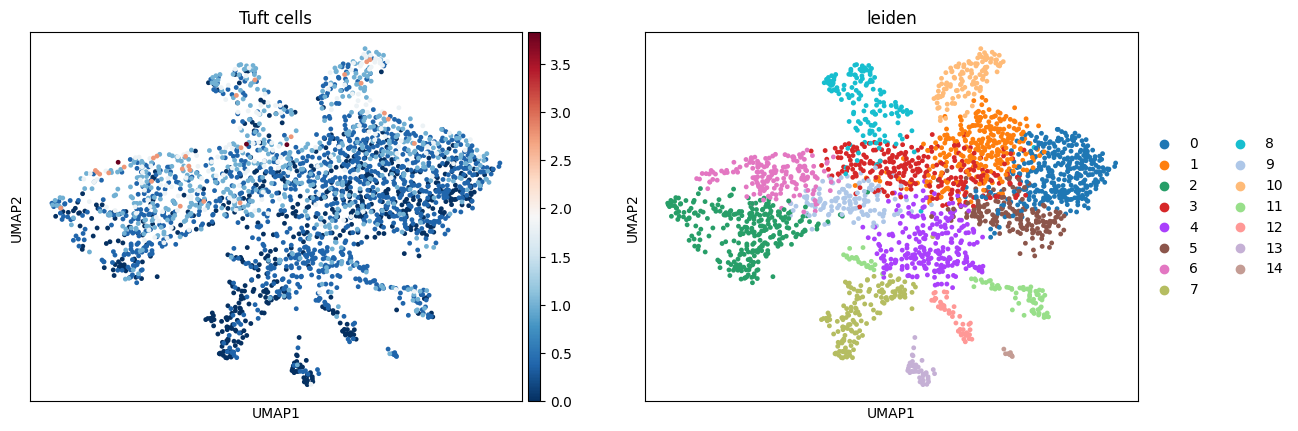

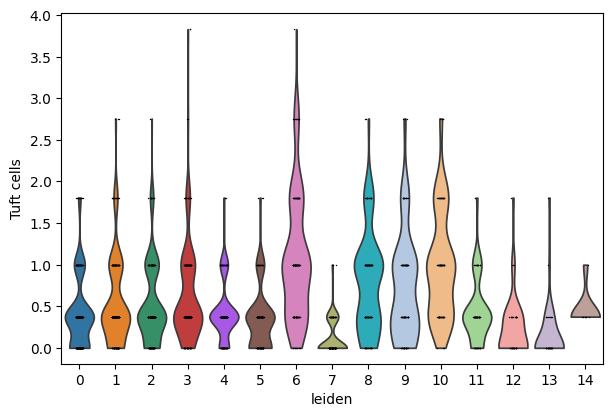

In [18]:
sc.pl.umap(acts, color=['Tuft cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['Tuft cells'], groupby='leiden')

In [12]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')

In [13]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Osteoclasts', 'Erythroblasts', 'Osteoblasts'],
 '1': ['Osteoblasts', 'B cells memory', 'Osteoclasts'],
 '10': ['T cells', 'Tuft cells', 'Mast cells'],
 '11': ['Erythroid-like and erythroid precursor cells',
  'Erythroblasts',
  'Gamma delta T cells'],
 '12': ['Natural killer T cells', 'Epiblast cells', 'Crypt cells'],
 '13': ['Erythroblasts', 'Osteoclasts', 'Mast cells'],
 '14': ['Mast cells', 'Epiblast cells', 'Airway goblet cells'],
 '2': ['Gamma delta T cells', 'B cells', 'B cells naive'],
 '3': ['B cells naive', 'B cells', 'T cells'],
 '4': ['Natural killer T cells', 'Osteoclasts', 'Gamma delta T cells'],
 '5': ['Gamma delta T cells', 'Crypt cells', 'Airway goblet cells'],
 '6': ['Tuft cells', 'T cells', 'B cells'],
 '7': ['Epiblast cells', 'Osteoblasts', 'Natural killer T cells'],
 '8': ['B cells', 'Erythroblasts', 'Osteoblasts'],
 '9': ['Gamma delta T cells', 'T cells', 'B cells']}

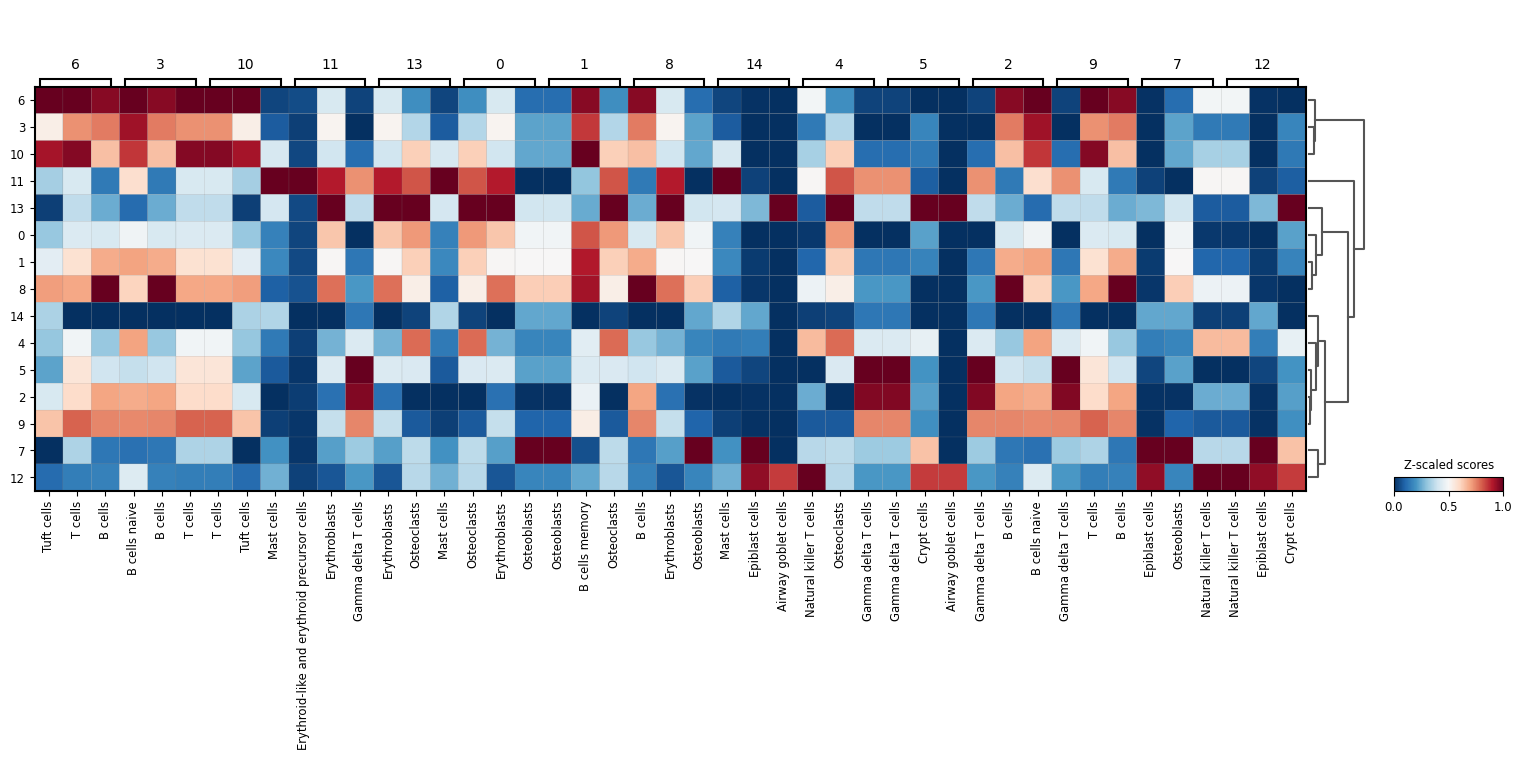

In [14]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

In [26]:
df[(df["pvals_adj"] < 0.05) & (df["meanchange"] > 0.5)]

,group,reference,names,statistic,meanchange,pvals,pvals_adj
51,11,rest,Erythroid-like and erythroid precursor cells,12.050665,3.740093,1.263913e-20,2.148653e-19
52,11,rest,Erythroblasts,5.410513,0.619455,2.084392e-07,8.858668e-07
53,11,rest,Gamma delta T cells,4.827636,1.219568,3.045672e-06,1.035529e-05
56,11,rest,Mast cells,2.963823,0.586058,3.866439e-03,7.303274e-03
69,12,rest,Epiblast cells,5.473254,0.639034,9.671981e-07,5.480789e-06
85,13,rest,Erythroblasts,4.354829,0.746891,4.144693e-05,3.522989e-04
86,13,rest,Osteoclasts,3.097098,0.593601,2.795745e-03,1.188192e-02
119,2,rest,Gamma delta T cells,14.623425,2.166610,2.271540e-41,3.861619e-40
170,5,rest,Gamma delta T cells,10.734046,2.191208,1.975650e-23,3.358605e-22
187,6,rest,Tuft cells,8.126291,0.565414,1.139749e-14,1.937573e-13


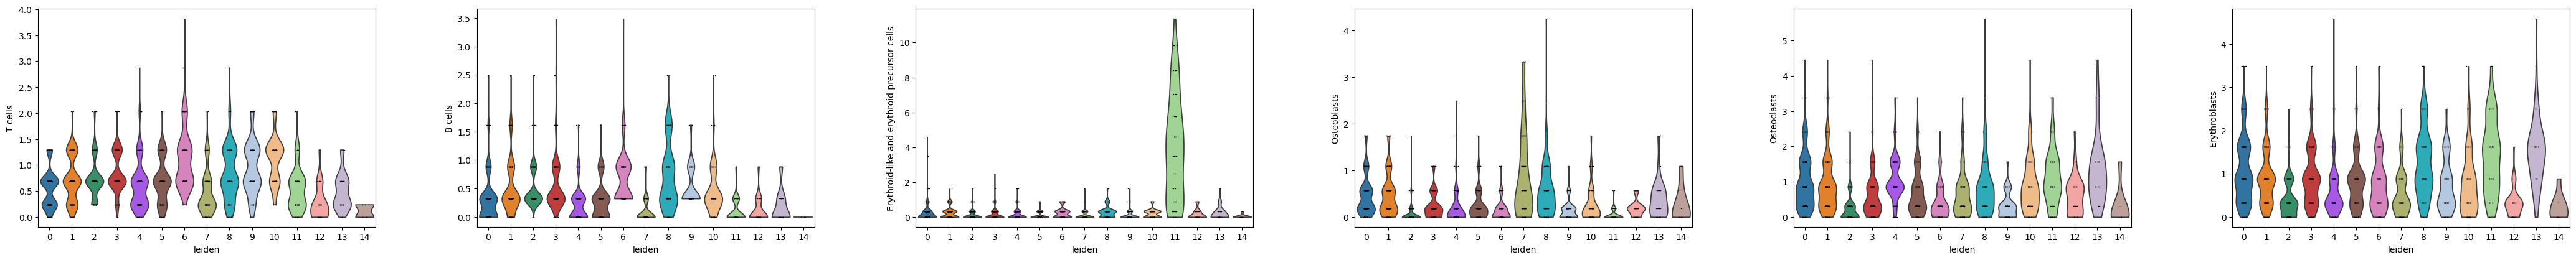

In [27]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Erythroid-like and erythroid precursor cells', 'Osteoblasts', 'Osteoclasts', 'Erythroblasts'], groupby='leiden')

In [ ]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict


In [ ]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type')